# Model Deployment

**Enhancing Loan Approval with Machine Learning: A Solution for Financial Inclusion**

* The project aims to address the problem of individuals struggling to obtain loans due to inadequate credit histories, which makes them vulnerable to unreliable lenders. Home Credit, a loan provider, seeks to enhance their loan approval process by leveraging statistical and machine learning techniques to predict applicants' ability to repay loans accurately.

* The project encompasses tasks such as feature engineering, model development, and evaluation. The CatBoost algorithm, with its powerful gradient boosting capabilities, is employed to build a predictive model. Model performance is evaluated using various metrics, including classification report and confusion matrix. Visualizations, such as plots of the classification report and confusion matrix, aid in better understanding the results.

* The project not only offers an opportunity for participants to showcase their analytical and modeling skills but also contributes to a real-world problem, helping Home Credit make informed decisions in loan approvals and enhance financial inclusivity.

**We aim to create a fairer and more accurate loan assessment process, ultimately improving financial access for individuals with limited or no credit histories.**

In [ ]:
# pip install catboost

In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix,accuracy_score,recall_score,precision_score,classification_report,roc_auc_score
import shap
import catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# To visualize data
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Import tools
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [27]:
cat_col_final = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']
num_col_final = ['TARGET','EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE']

In [28]:
#. load the training data ## Pipeline for Data Processing
df = pd.read_csv('data_new.csv')
df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE
0,Cash loans,F,N,Commercial associate,Secondary / secondary special,0,0.555561,0.514747,-2671.0,-1482.0
1,Revolving loans,M,Y,Working,Secondary / secondary special,0,0.577857,0.380800,-2382.0,-1109.0
2,Cash loans,F,N,State servant,Secondary / secondary special,0,0.749873,0.542445,-8297.0,-2255.0
3,Cash loans,F,N,Pensioner,Secondary / secondary special,0,0.680649,0.424130,-255.0,-192.0
4,Cash loans,F,N,Working,Higher education,0,0.526164,0.597192,-8665.0,-1209.0


In [29]:
y = df['TARGET']
X = df[num_col_final + cat_col_final].drop('TARGET', axis = 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42
                                                   )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6487102	best: 0.6487102 (0)	total: 51.1ms	remaining: 51s
200:	test: 0.7483039	best: 0.7504947 (189)	total: 11.8s	remaining: 46.8s
400:	test: 0.7526855	best: 0.7549470 (332)	total: 24.2s	remaining: 36.1s
600:	test: 0.7487986	best: 0.7549470 (332)	total: 36.6s	remaining: 24.3s
800:	test: 0.7470318	best: 0.7549470 (332)	total: 48.9s	remaining: 12.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7549469965
bestIteration = 332

Shrink model to first 333 iterations.
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       566
           1       0.40      0.08      0.13        50

    accuracy                           0.92       616
   macro avg       0.66      0.53      0.54       616
weighted avg       0.88      0.92      0.89       616


Test-set Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0          560            6
Actual 1           46            4


<Figure size 1000x800 with 0 Axes>

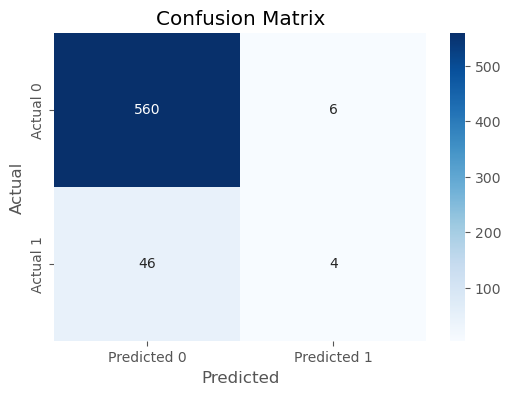

In [31]:
# Set figure size for better visualization
plt.figure(figsize=(10, 8))

# Define model parameters
params = {
    'learning_rate': 0.1,
    'cat_features': cat_col_final,
    'depth': 6,
    'eval_metric': 'AUC',
    'verbose': 200,
    'od_type': "Iter",  # overfit detector
    'od_wait': 500  # most recent best iteration to wait before stopping
    # 'random_seed': 2,
    # 'n_estimators': 200
}

# Create and train the CatBoost classifier
cat_model = catboost.CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              use_best_model=True,  # True if we don't want to save trees created after iteration with the best validation score
              plot=True
              )

# Make predictions on the test set
pred = cat_model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, pred))

# Print test-set confusion matrix
print("\nTest-set Confusion Matrix:\n")
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, pred))
confusion_matrix_df.columns = ['Predicted 0', 'Predicted 1']
confusion_matrix_df.index = ['Actual 0', 'Actual 1']
print(confusion_matrix_df)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
cat_model.save_model('default_detector_catboost')

In [33]:
# Create a SHAP explainer for cat_model
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_test)

shapvaluedf = pd.DataFrame(shap_values.values, columns= X.columns)
shapdatadf = pd.DataFrame(shap_values.data, columns= X.columns)

shapdatadf.to_csv(r'shapdatadf.csv')
shapvaluedf.to_csv(r'shapvaluedf.csv')